In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.preprocessing import StandardScaler

I have previously scraped a bunch of data about DnD monsters from [orcpub](http://www.orcpub.com/dungeons-and-dragons/5th-edition/monsters) using `MonsterScraper.py`. The first thing I want to do is load the data from the created csv file into a dataframe.

In [426]:
df = pd.read_csv('out_monsters.csv')
df.head()

,Name,Size,Type,Alignment,AC,HP,Hit Die,Speed,Str,Dex,...,Skills,Resistance,Immunity,Condition Immunity,Senses,Languages,CR,Extras,Actions,Leg Actions
0,Aboleth,Large,aberration,lawful evil,17,135,(18d10+ 36),"10 ft., swim 40 ft. ft.",21 (+5),9 (-1),...,"History +12, Perception +10",NaN,NaN,NaN,"darkvision 120 ft., passive Perception 20","Deep Speech, telepathy 120 ft.",10(5900 XP),Amphibious.Mucous Cloud.Probing Telepathy.,Multiattack.Tentacle.Tail.Enslave .,Detect.Tail Swipe.Psychic Drain .
1,Deva,Medium,celestial,lawful good,17,136,(16d8+ 64),"30 ft., fly 90 ft. ft.",18 (+4),18 (+4),...,"Insight +9, Perception +9","radiant; bludgeoning, piercing, and slashing f...",NaN,"charmed, exhaustion, frightened","darkvision 120 ft., passive Perception 19","all, telepathy 120 ft.",10(5900 XP),Angelic Weapons.Innate Spellcasting.Magic Resi...,Multiattack.Mace.Healing Touch .Change Shape.,NaN
2,Planetar,Large,celestial,lawful good,19,200,(16d10+ 112),"40 ft., fly 120 ft. ft.",24 (+7),20 (+5),...,Perception +11,"radiant; bludgeoning, piercing, and slashing f...",NaN,"charmed, exhaustion, frightened","truesight 120 ft., passive Perception 21","all, telepathy 120 ft.",16(15000 XP),Angelic Weapons.Divine Awareness.Innate Spellc...,Multiattack.Greatsword.Healing Touch .,NaN
3,Solar,Large,celestial,lawful good,21,243,(18d10+ 144),"50 ft., fly 150 ft. ft.",26 (+8),22 (+6),...,Perception +14,"radiant; bludgeoning, piercing, and slashing f...","necrotic, poison","charmed, exhaustion, frightened, poisoned","truesight 120 ft., passive Perception 24","all, telepathy 120 ft.",21(33000 XP),Angelic Weapons.Divine Awareness.Innate Spellc...,Multiattack.Greatsword.Slaying Longbow.Flying ...,Teleport.Searing Burst .Blinding Gaze .
4,Animated Armor,Medium,construct,unaligned,18,33,(6d8+ 6),25 ft. ft.,14 (+2),11 (0),...,NaN,NaN,"poison, psychic","blinded, charmed, deafened, exhaustion, fright...","blindsight 60 ft. (blind beyond this radius), ...",NaN,1(200 XP),Antimagic Susceptibility.False Appearance.,Multiattack.Slam.,NaN


Let's take a look at all of the columns available

In [427]:
print(df.columns)

Index(['Name', 'Size', 'Type', 'Alignment', 'AC', 'HP', 'Hit Die', 'Speed',
       'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha', 'Proficiency', 'Skills',
       'Resistance', 'Immunity', 'Condition Immunity', 'Senses', 'Languages',
       'CR', 'Extras', 'Actions', 'Leg Actions'],
      dtype='object')


## Basic Data Cleaning

It's easy to see that some of the data that is likely important to understanding the strength of a monster needs to be cleaned. This includes hit die, and the attributes such as strength, dexterity, etc. First, I am going to make three columns representing the number of die, the type of die, and the additional modifier.

In [428]:
#not the nicest/most efficient, gets the job done for now
# new data frame with split value columns 
#Remove the brackets from the column
def sanitize_hit_die(word):
    #clean up parentheses
    word = word.translate(str.maketrans('','','()'))
    #check for offset modifier, if not add a + 0
    if not re.search('\+|\-',word):
        word += '+ 0'
    #are we using positive or negative modifiers?
    sign = re.findall('\+|\-',word)
    word_list = re.split('\D |\D',word)
    word_list[2] = sign[0] + word_list[2]
    return word_list
 
df[["N Hit Die", "Dice", "Offset"]] = df['Hit Die'].apply(lambda row: pd.Series(sanitize_hit_die(row)))  
    
df = df.drop("Hit Die",axis=1)

df.head()




,Name,Size,Type,Alignment,AC,HP,Speed,Str,Dex,Con,...,Condition Immunity,Senses,Languages,CR,Extras,Actions,Leg Actions,N Hit Die,Dice,Offset
0,Aboleth,Large,aberration,lawful evil,17,135,"10 ft., swim 40 ft. ft.",21 (+5),9 (-1),15 (+2),...,NaN,"darkvision 120 ft., passive Perception 20","Deep Speech, telepathy 120 ft.",10(5900 XP),Amphibious.Mucous Cloud.Probing Telepathy.,Multiattack.Tentacle.Tail.Enslave .,Detect.Tail Swipe.Psychic Drain .,18,10,+36
1,Deva,Medium,celestial,lawful good,17,136,"30 ft., fly 90 ft. ft.",18 (+4),18 (+4),18 (+4),...,"charmed, exhaustion, frightened","darkvision 120 ft., passive Perception 19","all, telepathy 120 ft.",10(5900 XP),Angelic Weapons.Innate Spellcasting.Magic Resi...,Multiattack.Mace.Healing Touch .Change Shape.,NaN,16,8,+64
2,Planetar,Large,celestial,lawful good,19,200,"40 ft., fly 120 ft. ft.",24 (+7),20 (+5),24 (+7),...,"charmed, exhaustion, frightened","truesight 120 ft., passive Perception 21","all, telepathy 120 ft.",16(15000 XP),Angelic Weapons.Divine Awareness.Innate Spellc...,Multiattack.Greatsword.Healing Touch .,NaN,16,10,+112
3,Solar,Large,celestial,lawful good,21,243,"50 ft., fly 150 ft. ft.",26 (+8),22 (+6),26 (+8),...,"charmed, exhaustion, frightened, poisoned","truesight 120 ft., passive Perception 24","all, telepathy 120 ft.",21(33000 XP),Angelic Weapons.Divine Awareness.Innate Spellc...,Multiattack.Greatsword.Slaying Longbow.Flying ...,Teleport.Searing Burst .Blinding Gaze .,18,10,+144
4,Animated Armor,Medium,construct,unaligned,18,33,25 ft. ft.,14 (+2),11 (0),13 (+1),...,"blinded, charmed, deafened, exhaustion, fright...","blindsight 60 ft. (blind beyond this radius), ...",NaN,1(200 XP),Antimagic Susceptibility.False Appearance.,Multiattack.Slam.,NaN,6,8,+6


Now I will break apart the abilities and their modifiers while also sanitizing. It will be helpful to have a function do the work as I will need to do this multiple times.

In [429]:
def sanitize_abilities(word):
    return re.split('[\(\)]', word)[0:2]
        
df[['Str','Str_mod']] = df['Str'].apply(lambda row: pd.Series(sanitize_abilities(row)))
df[['Dex','Dex_mod']] = df['Dex'].apply(lambda row: pd.Series(sanitize_abilities(row)))
df[['Cha','Cha_mod']] = df['Cha'].apply(lambda row: pd.Series(sanitize_abilities(row)))
df[['Con','Con_mod']] = df['Con'].apply(lambda row: pd.Series(sanitize_abilities(row)))
df[['Wis','Wis_mod']] = df['Wis'].apply(lambda row: pd.Series(sanitize_abilities(row)))
df[['Int','Int_mod']] = df['Int'].apply(lambda row: pd.Series(sanitize_abilities(row)))


The last thing I'm going to do for basic numeric values is break apart the CR and XP values. These currently look like this:

In [430]:
df.CR.head()

0     10(5900 XP)
1     10(5900 XP)
2    16(15000 XP)
3    21(33000 XP)
4       1(200 XP)
Name: CR, dtype: object

Here I will seperate the CR and XP values, and put them in their own columns.

In [431]:
def clean_CR(word):
    columns = word.split('(')
    columns[1] = columns[1].split()[0]
    return columns
    
df[['CR','XP']] = df['CR'].apply(lambda row: pd.Series(clean_CR(row)))
df[['XP','CR']].head() #shows section we are interested to see if it worked

,XP,CR
0,5900,10
1,5900,10
2,15000,16
3,33000,21
4,200,1


The quantitative features should be converted to numeric values. 
As shown below, ability values are currently given as strings. Some of the numeric values are also given as fractions and need to be converted to floats by hand. This creates the need to use a custom float creator before the `pd.to_numeric`

In [432]:
print(df.dtypes)

Name                   object
Size                   object
Type                   object
Alignment              object
AC                      int64
HP                      int64
Speed                  object
Str                    object
Dex                    object
Con                    object
Int                    object
Wis                    object
Cha                    object
Proficiency           float64
Skills                 object
Resistance             object
Immunity               object
Condition Immunity     object
Senses                 object
Languages              object
CR                     object
Extras                 object
Actions                object
Leg Actions            object
N Hit Die              object
Dice                   object
Offset                 object
Str_mod                object
Dex_mod                object
Cha_mod                object
Con_mod                object
Wis_mod                object
Int_mod                object
XP        

In [433]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [434]:
make_num_list = ["Str","Dex","Con","Int","Wis","Cha","N Hit Die","Dice","Offset","Str_mod","Dex_mod","Cha_mod","Con_mod","Wis_mod","Int_mod","XP","CR"]
#make_num_list = "Str"
df[make_num_list] = df[make_num_list].applymap(convert_to_float)

## Initial Checks
One would expect XP and CR to be related. The amount of correlation should be checked, as it is very likely that the XP is deduced from the CR. If this is the case it would lead to leakage in our model.

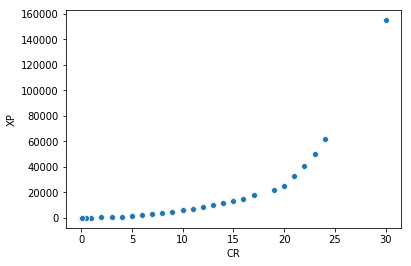

In [435]:
sns.scatterplot(x=df.CR,y=df.XP)
plt.show()

There is an interesting trend between the XP given out and the CR of a monster. There is also clearly not a lot of scatter between each CR and XP. Looking for the number of unique XP values for each CR clearly shows that there is a one-to-one relationship between CR and XP. Clearly we must not use XP for modelling the determination of CR as we will have significant data leakage.

In [436]:
df.groupby('CR').XP.nunique()

CR
0.000     1
0.125     1
0.250     1
0.500     1
1.000     1
2.000     1
3.000     1
4.000     1
5.000     1
6.000     1
7.000     1
8.000     1
9.000     1
10.000    1
11.000    1
12.000    1
13.000    1
14.000    1
15.000    1
16.000    1
17.000    1
19.000    1
20.000    1
21.000    1
22.000    1
23.000    1
24.000    1
30.000    1
Name: XP, dtype: int64

Now, we want to simplify the feature list to look at the basic quantitative features without XP. Perhaps we will go back to the more complicated traits later.

In [437]:
X_list = ["Str","Dex","Con","Int","Wis","Cha","N Hit Die","Dice","Offset","Str_mod","Dex_mod","Cha_mod","Con_mod","Wis_mod","Int_mod","Proficiency","AC","HP"]
X = df[X_list]  
y_list = ["CR"]
y = df[y_list]

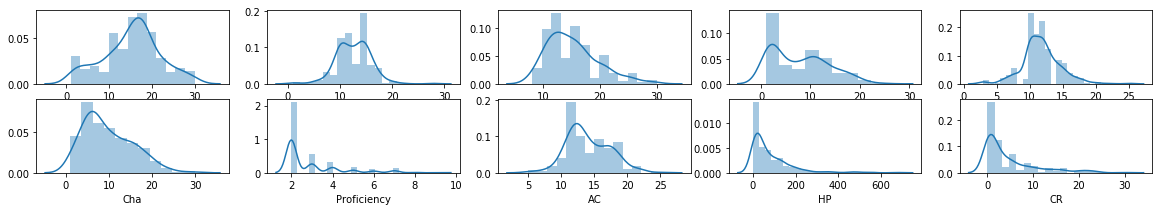

In [440]:
fig, axs = plt.subplots(figsize=(20,3),ncols=5,nrows=2)
sns.distplot(a=X.Str,ax=axs[0][0])
sns.distplot(a=X.Dex,ax=axs[0][1])
sns.distplot(a=X.Con,ax=axs[0][2])
sns.distplot(a=X.Int,ax=axs[0][3])
sns.distplot(a=X.Wis,ax=axs[0][4])
sns.distplot(a=X.Cha,ax=axs[1][0])
sns.distplot(a=X.Proficiency,ax=axs[1][1])
sns.distplot(a=X.AC,ax=axs[1][2])
sns.distplot(a=X.HP,ax=axs[1][3])
sns.distplot(a=y.CR,ax=axs[1][4])
plt.show()